### Simulate RDD Data 

# Make some choices

Running this cell will define the variables of interest, our hyperparameters and some training options.

Make sure your Google Colab runtime has a GPU. You can turn this on via:

`Runtime -> Change Runtime type -> Hardware Accelerator -> GPU`

In [1]:
import wgan
import torch
import pandas as pd
from rdd import rdd 
import numpy as np
import importlib
importlib.reload(wgan)
#assert torch.cuda.is_available()

# T | X 

<module 'wgan' from '/Users/evanmunro/.pyenv/versions/3.9.1/lib/python3.9/site-packages/wgan/__init__.py'>

### Matsudaira data 

In [2]:
file = "../data/cleaned/jl_math.csv"
df = pd.read_csv(file)
df.head() 

,z1,z2,x,y
0,2.6,2.2,-0.55,-1.4030
1,4.2,3.6,0.85,-0.3211
2,4.1,4.0,1.25,-0.3685
3,3.3,2.7,-0.05,-1.3479
4,3.5,3.2,0.45,-0.3211


In [3]:
dfa = df[df['x']>0].copy()#.head(1000)
print(dfa.head())

dfb = df[df['x']<=0].copy()#.head(1000)

#dfs = pd.concat([dfa,dfb],axis=0,ignore_index=True)

    z1   z2     x       y
1  4.2  3.6  0.85 -0.3211
2  4.1  4.0  1.25 -0.3685
4  3.5  3.2  0.45 -0.3211
6  4.0  3.7  0.95  0.6031
7  3.7  4.7  0.95 -1.0933


In [5]:
cd = [128, 128, 128]
gd = [128, 128, 128]
#penalty=4
batch=3000
penalty = 5
noise = 2
dropout = 0.1
epochs = 2000
steps = 25 
copt = torch.optim.Adam
gopt = wgan.OAdam
epochs = 50 

## Generate X jointly 

In [8]:
#Generate X alone 
dwx = wgan.DataWrapper(df,["x"])
x,context = dwx.preprocess(df)
specs = wgan.Specifications(dwx,
                            batch_size=batch, 
                            max_epochs=50,
                            critic_d_hidden=[128,128,128],
                            generator_d_hidden=[128, 128, 128],
                            generator_d_noise=2, 
                            critic_gp_factor=penalty, 
                            optimizer=copt, 
                            generator_optimizer = gopt, 
                            critic_steps = steps, 
                            generator_lr=0.0001, 
                            critic_lr = 0.0001, 
                            print_every=100)
generatorx = wgan.Generator(specs)
criticx = wgan.Critic(specs)

settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 25, 'critic_lr': 0.0001, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 0.0001, 'generator_d_noise': 2, 'generator_optimizer': <class 'wgan.wgan.OAdam'>, 'max_epochs': 50, 'batch_size': 3000, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'device': 'cpu'}


In [27]:
wgan.train(generatorx, criticx, x, context, specs)

epoch 0 | step 25 | WD_test 0.11 | WD_train 0.13 | sec passed 1 |


## Generate Y|X above and below the cutoff 

In [30]:
#Generate Y | X, above and below cutoff 
#smaller batch size of 500 

dwya = wgan.DataWrapper(dfa,["y"],context_vars=["x"])
xa, contexta = dwya.preprocess(dfa)
specsa  = wgan.Specifications(dwya,
                              batch_size=batch, 
                            max_epochs=150,
                            critic_d_hidden=[128,128,128],
                            generator_d_hidden=[128, 128, 128],
                            generator_d_noise=2, 
                            critic_gp_factor=penalty, 
                            optimizer=copt, 
                            generator_optimizer = gopt, 
                            critic_steps = steps, 
                            generator_lr=0.0001, 
                            critic_lr = 0.0001, 
                            print_every=100)

#above cutoff
generatorya = wgan.Generator(specsa)
criticya = wgan.Critic(specsa)

dwyb = wgan.DataWrapper(dfb,["y"],context_vars=["z1","z2"])
print(dwyb.means)
print(dwyb.stds) 
#below cutoff 
specsb  = wgan.Specifications(dwyb,
                              batch_size=batch, 
                            max_epochs=150,
                            critic_d_hidden=[128,128,128],
                            generator_d_hidden=[128, 128, 128],
                            generator_d_noise=2, 
                            critic_gp_factor=penalty, 
                            optimizer=copt, 
                            generator_optimizer = gopt, 
                            critic_steps = steps, 
                            generator_lr=0.0001, 
                            critic_lr = 0.0001, 
                            print_every=100)
xb,contextb = dwyb.preprocess(dfb)
generatoryb = wgan.Generator(specsb)
criticyb = wgan.Critic(specsb)

settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 25, 'critic_lr': 0.0001, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 0.0001, 'generator_d_noise': 2, 'generator_optimizer': <class 'wgan.wgan.OAdam'>, 'max_epochs': 150, 'batch_size': 3000, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'device': 'cpu'}
[tensor([[-1.0376]]), tensor([[2.8055, 2.1955]])]
[tensor([[0.8038]]), tensor([[0.6458, 0.6234]])]
settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 25, 'critic_lr': 0.0001, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 0.0001, 'generator_d_noise': 2, 'generator_optimizer': <class 'wgan.wgan.OAdam'>, 'max_epochs': 150, 'batch_size': 3000, 'test_set_size

In [ ]:
wgan.train(generatoryb, criticyb, xb, contextb, specsb)
wgan.train(generatorya, criticya, xa, contexta, specsa)

epoch 0 | step 11 | WD_test 0.05 | WD_train 0.01 | sec passed 1 |


## Test Generated Data 

In [19]:
def apply_models(df): 
    s = dwx.apply_generator(generatorx,df)
    #s["x"] = s[["z1","z2"]].min(axis=1)-2.75
    print(s.head())
    #s['w'] = s['x']<0 
    sa = s[s['x']>0]
    sb = s[s['x']<=0] 
   # sa = dwya.apply_generator(generatorya,sa) 
   # sb = dwyb.apply_generator(generatoryb,sb)
   
    return pd.concat([sa,sb],axis=0,ignore_index=True)

def apply_below(dfb): 
    print(dwyb.means) 
    dfb = dwyb.apply_generator(generatoryb,dfb)
    return dfb 

def apply_above(dfa): 
    dfa = dwya.apply_generator(generatorya,dfa)
    return dfa 

In [11]:
df.head()

,z1,z2,x,y
0,2.6,2.2,-0.55,-1.4030
1,4.2,3.6,0.85,-0.3211
2,4.1,4.0,1.25,-0.3685
3,3.3,2.7,-0.05,-1.3479
4,3.5,3.2,0.45,-0.3211


  source   z1   z2         x       y
0   real  2.6  2.2 -0.294668 -1.4030
1   real  4.2  3.6 -0.751225 -0.3211
2   real  4.1  4.0  3.089581 -0.3685
3   real  3.3  2.7 -0.062392 -1.3479
4   real  3.5  3.2  1.333494 -0.3211


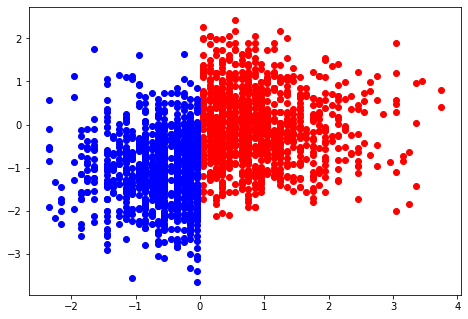

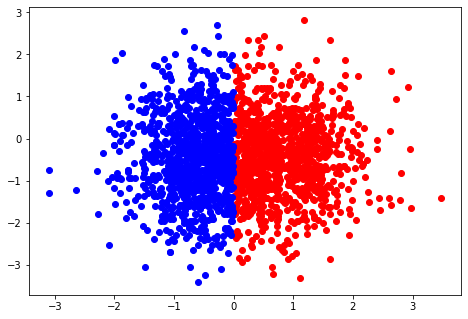

In [28]:
import matplotlib.pyplot as plt
df_fake = apply_models(df)
#df_fake = apply_joint(dfa,dfb)
df_fa = df_fake[df_fake['x']>0] 
df_fb = df_fake[df_fake['x']<=0] 
#df_fb = apply_below(dfb) 
#df_fa = apply_above(dfa) 

fig=plt.figure() 
ax=fig.add_axes([0,0,1,1])
ax.scatter(dfa['x'].sample(1000),dfa['y'].sample(1000), color='r')
ax.scatter(dfb['x'].sample(1000),dfb['y'].sample(1000), color='b')

fig2=plt.figure() 
ax=fig2.add_axes([0,0,1,1])
ax.scatter(df_fa['x'].sample(1000),df_fa['y'].sample(1000), color='r')
ax.scatter(df_fb['x'].sample(1000),df_fb['y'].sample(1000), color='b')


In [19]:
rdd_estimate(df_fake.sample(7000))

1.2880649122459296
Estimation Equation:	 y ~ TREATED + x


-1.0556792343184291

In [18]:
rdd_estimate(df.sample(8000))

0.845730843547923
Estimation Equation:	 y ~ TREATED + x


-0.1425750348914838

In [267]:
def rdd_fuzzy(data,h):
    data = data[data["x"].abs()<=h]
    da = data[data['x']>0]
    db = data[data['x']<=0]
    denom = da['y'].mean() - db['y'].mean()
    num = da['t'].mean() - db['t'].mean() 
    print(denom)
    print(num)
    est = (da['y'].mean() - db['y'].mean())/(da['t'].mean() - db['t'].mean())
    return est 

Finally, we can examine our generated data with the `compare_dfs` function.


In [15]:
def rdd_estimate(data):
    bandwidth_opt = rdd.optimal_bandwidth(data['y'], data['x'], cut=0) 
    print(bandwidth_opt)
    data_rdd = rdd.truncated_data(data, 'x', bandwidth_opt, cut=0) 
    model = rdd.rdd(data_rdd, 'x', 'y', cut=0)
    return model.fit().params[1]

In [9]:
# Option 2: load trained model parameters
def load_saved_parameters(type):
    for model, name in zip([generatorx, criticx,
                          generatorya, criticya,
                          generatoryb, criticyb],
                         ["Gx","Cx","Gya","Cya","Gyb","Cyb"]):
        state_dict = torch.load("../trained_models/" + name + "_{}.pth".format(type))
        model.load_state_dict(state_dict)

load_saved_parameters("jl_math")

In [25]:
def evaluate_results():
  # Let's print the att!
  print("--------------------RDD--------------------")
  #print("real:",rdd_estimate(df)) 
  #print("fake:",rdd_estimate(df_fake))

  # Now, we'll compare our fake data to the real data
  table_groupby = ["t"]
  scatterplot = dict(x= ["x"],
                     y= ["y"],
                     samples = 5000, smooth = 1)
  histogram = dict(variables=['x','y','z1','z2'],
                   nrow=2, ncol=2)
  wgan.compare_dfs(df, df_fake, figsize=5, histogram=histogram, scatterplot=scatterplot)


--------------------RDD--------------------
-------------comparison of means-------------
source  fake  real
z1      3.54  3.54
z2      3.13  3.13
x       0.13  0.23
y      -0.44 -0.44
-------------comparison of stds-------------
source  fake  real
z1      0.95  0.95
z2      1.09  1.09
x       0.94  0.98
y       0.98  0.98


/Users/evanmunro/.pyenv/versions/3.9.1/lib/python3.9/site-packages/wgan/wgan.py:670: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
/Users/evanmunro/.pyenv/versions/3.9.1/lib/python3.9/site-packages/wgan/wgan.py:702: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()


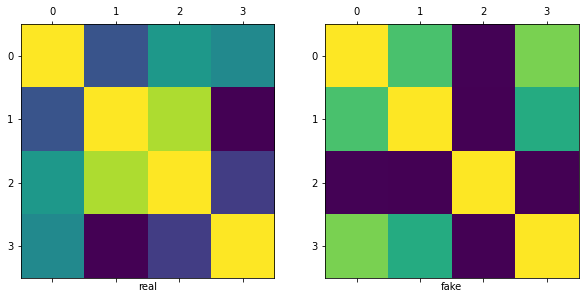

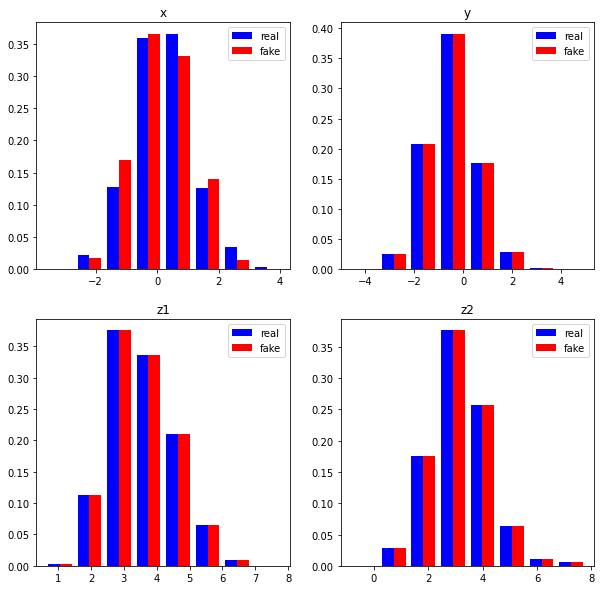

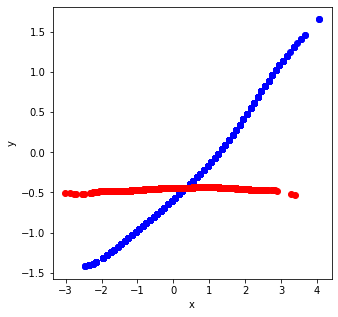

In [29]:
evaluate_results()

Looks good enough? Then save the models, generate a large dataframe and export it.

In [33]:
# save trained model parameters
def save_trained_parameters(type):
  #%mkdir trained_models
  for model, name in zip([generatorx, criticx,
                          generatorya, criticya,
                          generatoryb, criticyb  
                                              ], 
                         ["Gx","Cx","Gya","Cya","Gyb","Cyb"]):
    torch.save(model.state_dict(), "trained_models/" + name + "_{}.pth".format(type))

In [34]:
save_trained_parameters("jl_math")

In [18]:
# generate and save data of a certain sample size
def save_generated_data(type,n):
    s = df.sample(int(n),replace=True)
    df_fake = apply_models(s)
    df_fake.to_feather("data/generated/{}_generated.feather".format(type))

In [300]:
dfa.shape[0]

47589

In [35]:
save_generated_data("jl_math",10000000)

  source        z1        z2         x       y
0   real  2.980183  2.487857 -0.262143  0.7379
1   real  4.551961  3.194024  0.444024 -0.4297
2   real  3.893134  2.749398 -0.000602  0.7741
3   real  4.538335  3.909431  1.159431 -1.4694
4   real  4.502318  3.869498  1.119498 -1.2200


### Generating Figures

In [401]:
gen_data1 = df_fake[df_fake["x"]>0].copy()
real_data1 = df[df["x"]>0].copy() 

gen_data2 = df_fake[df_fake["x"]<=0].copy()
real_data2 = df[df["x"]<=0].copy() 

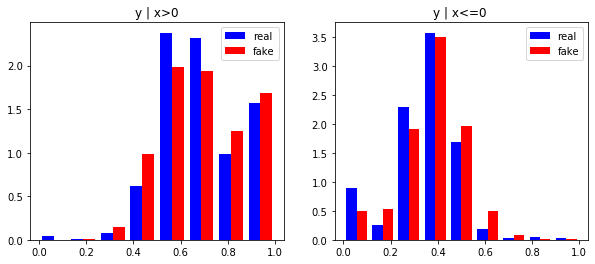

In [403]:
fig1, axarr = plt.subplots(1,2,figsize=(10, 4))
axarr[0].hist([real_data1["y"],gen_data1["y"]], bins=8, density=1,
                histtype='bar', label=["real", "fake"], color=["blue", "red"])
axarr[1].hist([real_data2["y"],gen_data2["y"]],bins=9,density=1,histtype='bar',
                  label=["real","fake"], color=["blue","red"])
axarr[0].legend(prop={"size": 10})
axarr[0].set_title("y | x>0")

axarr[1].legend(prop={"size": 10})
axarr[1].set_title("y | x<=0 ")
fig1.savefig("y_splithist.pdf")

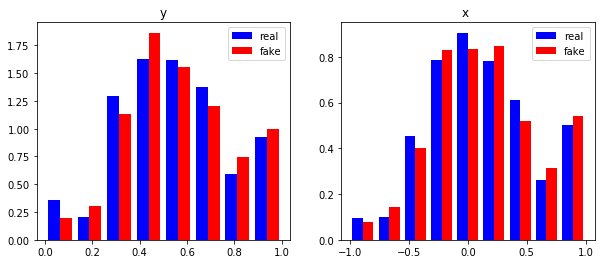

In [404]:
fig2, axarr = plt.subplots(1,2,figsize=(10, 4))
axarr[0].hist([df["y"],df_fake["y"]], bins=8, density=1,
                histtype='bar', label=["real", "fake"], color=["blue", "red"])
axarr[1].hist([df["x"],df_fake["x"]],bins=9,density=1,histtype='bar',
                  label=["real","fake"], color=["blue","red"])
axarr[0].legend(prop={"size": 10})
axarr[0].set_title("y")

axarr[1].legend(prop={"size": 10})
axarr[1].set_title("x ")
fig2.savefig("uncond_hist.pdf")

In [ ]:
fig=plt.figure() 
ax=fig.add_axes([0,0,1,1])
ax.scatter(context2b.numpy(),x2b.numpy(), color='b')
ax.scatter(context2a.numpy(),x2a.numpy(), color='r')


fig=plt.figure() 
ax=fig.add_axes([0,0,1,1])
ax.scatter(dfa['x'],dfa['y'], color='r')
ax.scatter(dfb['x'],dfb['y'], color='b')

u_da = data_wrapper2.deprocess(x2a,context2a)
u_db = data_wrapper2.deprocess(x2b,context2b)

fig=plt.figure() 
ax=fig.add_axes([0,0,1,1])
ax.scatter(u_da['x'],u_da['y'], color='r')
ax.scatter(u_db['x'],u_db['y'], color='b')



## Generate joint

In [ ]:
dwj = wgan.DataWrapper(dfs,["y"],context_vars=["x"])
specs  = wgan.Specifications(dwj,
                              batch_size=500,
                              max_epochs=500,
                              generator_d_noise=3,
                              critic_d_hidden=[128,128,128],
                              generator_d_hidden=[64,64,64],
                              critic_gp_factor=5, 
                              print_every=100,
                              generator_dropout=dropout)
x,context = dwj.preprocess(dfs)
generatorj = wgan.Generator(specs)
criticj = wgan.Critic(specs)